In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [3]:
training_tasks_files

['007bbfb7.json',
 '00d62c1b.json',
 '017c7c7b.json',
 '025d127b.json',
 '045e512c.json',
 '0520fde7.json',
 '05269061.json',
 '05f2a901.json',
 '06df4c85.json',
 '08ed6ac7.json',
 '09629e4f.json',
 '0962bcdd.json',
 '0a938d79.json',
 '0b148d64.json',
 '0ca9ddb6.json',
 '0d3d703e.json',
 '0dfd9992.json',
 '0e206a2e.json',
 '10fcaaa3.json',
 '11852cab.json',
 '1190e5a7.json',
 '137eaa0f.json',
 '150deff5.json',
 '178fcbfb.json',
 '1a07d186.json',
 '1b2d62fb.json',
 '1b60fb0c.json',
 '1bfc4729.json',
 '1c786137.json',
 '1caeab9d.json',
 '1cf80156.json',
 '1e0a9b12.json',
 '1e32b0e9.json',
 '1f0c79e5.json',
 '1f642eb9.json',
 '1f85a75f.json',
 '1f876c06.json',
 '1fad071e.json',
 '2013d3e2.json',
 '2204b7a8.json',
 '22168020.json',
 '22233c11.json',
 '2281f1f4.json',
 '228f6490.json',
 '22eb0ac0.json',
 '234bbc79.json',
 '23581191.json',
 '239be575.json',
 '23b5c85d.json',
 '253bf280.json',
 '25d487eb.json',
 '25d8a9c8.json',
 '25ff71a9.json',
 '264363fd.json',
 '272f95fa.json',
 '27a28665

In [4]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [5]:
training_tasks = load_files(training_path)
test_tasks = load_files(test_path)
evaluation_tasks = load_files(evaluation_path)

In [6]:
training_tasks[0]#['test'][0]

{'test': [{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]],
   'output': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 0, 7, 0, 0, 0, 7, 0, 7],
    [7, 7, 0, 0, 0, 0, 7, 7, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 0, 7, 7, 0, 7, 0, 0, 0],
    [7, 7, 0, 7, 7, 0, 0, 0, 0]]}],
 'train': [{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]],
   'output': [[0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7],
    [0, 7, 7, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7],
    [0, 0, 0, 7, 7, 7, 7, 7, 7],
    [0, 0, 0, 0, 7, 7, 0, 7, 7]]},
  {'input': [[4, 0, 4], [0, 0, 0], [0, 4, 0]],
   'output': [[4, 0, 4, 0, 0, 0, 4, 0, 4],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 4, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4

 
 ---
 ---

### 1. Create Train - Test - Split

In [7]:
Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

for task in training_tasks:
    X_test, y_test, X_train, y_train = [], [], [], []

    for pair in task["test"]:
        X_test.append(pair["input"])
        y_test.append(pair["output"])      ### to be predicted !!!

    for pair in task["train"]:
        X_train.append(pair["input"])
        y_train.append(pair["output"])
    
    Xs_test.append(X_test)
    ys_test.append(y_test)
    Xs_train.append(X_train)
    ys_train.append(y_train)

In [8]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [9]:
### put this in a fct later
# cv2.resize(np.asarray(train_data['input']), dsize=(32, 32), interpolation=cv2.INTER_NEAREST))

li=[]
for X_train in Xs_train:
    for e in X_train:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
X_train_big = np.array(li)

In [10]:
X_train_big = X_train_big / 10.
X_train_big = X_train_big.reshape(1301,32,32, 1)  #(x_train.shape + (1,) )

In [11]:
X_train_big.shape

(1301, 32, 32, 1)

In [12]:
li=[]
for X_test in Xs_test:
    for e in X_test:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
X_test_big = np.array(li)

In [13]:
X_test_big.shape

(416, 32, 32)

In [14]:
X_test_big = X_test_big / 10.
X_test_big = X_test_big.reshape(416,32,32, 1)  #(x_train.shape + (1,) )

In [15]:
K.clear_session()

latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape = (32,32,1)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(1024, activation='sigmoid'),
            layers.Reshape((32, 32,1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [16]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [17]:
autoencoder.fit(X_train_big, X_train_big,
                epochs=100,
                batch_size=5000,
                #shuffle=True,
                validation_data=(X_test_big, X_test_big))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2410 - accuracy: 0.4861 - val_loss: 0.2382 - val_accuracy: 0.5914
Epoch 2/100
1/1 [==============================] - 0s 347ms/step - loss: 0.2405 - accuracy: 0.6087 - val_loss: 0.2375 - val_accuracy: 0.6562
Epoch 3/100
1/1 [==============================] - 0s 373ms/step - loss: 0.2398 - accuracy: 0.6772 - val_loss: 0.2365 - val_accuracy: 0.6963
Epoch 4/100
1/1 [==============================] - 0s 347ms/step - loss: 0.2390 - accuracy: 0.7174 - val_loss: 0.2352 - val_accuracy: 0.7260
Epoch 5/100
1/1 [==============================] - 0s 392ms/step - loss: 0.2377 - accuracy: 0.7455 - val_loss: 0.2333 - val_accuracy: 0.7516
Epoch 6/100
1/1 [==============================] - 0s 359ms/step - loss: 0.2360 - accuracy: 0.7696 - val_loss: 0.2307 - val_accuracy: 0.7765
Epoch 7/100
1/1 [==============================] - 0s 490ms/step - loss: 0.2337 - accuracy: 0.7928 - val_loss: 0.2272 - val_accuracy: 0.8000
Epoch 8/100
1/1 

Epoch 59/100
1/1 [==============================] - 0s 376ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 60/100
1/1 [==============================] - 0s 355ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 61/100
1/1 [==============================] - 0s 375ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 62/100
1/1 [==============================] - 0s 375ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 63/100
1/1 [==============================] - 0s 325ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 64/100
1/1 [==============================] - 0s 357ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 65/100
1/1 [==============================] - 0s 350ms/step - loss: 0.0124 - accuracy: 0.9490 - val_loss: 0.0141 - val_accuracy: 0.9373
Epoch 

## get the ys involved too???


In [18]:
li=[]
for y_train in ys_train:
    for e in y_train:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
y_train_big = np.array(li)

In [19]:
y_train_big.shape

(1301, 32, 32)

In [20]:
y_train_big = y_train_big / 10.
y_train_big = y_train_big.reshape(1301,32,32, 1)  #(x_train.shape + (1,) )

In [21]:
y_train_big.shape

(1301, 32, 32, 1)

In [22]:
li=[]
for y_test in ys_test:
    for e in y_test:
        e = np.array(e)
        e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
        li.append(e)
y_test_big = np.array(li)

In [23]:
y_test_big.shape

(416, 32, 32)

In [24]:
y_test_big = y_test_big / 10.

In [25]:
y_test_big = y_test_big.reshape(416,32,32, 1)  #(x_train.shape + (1,) )

In [26]:
y_test_big.shape

(416, 32, 32, 1)

In [27]:
#X_train_big = X_train_big.reshape(1301,32,32, 1)
#X_test_big = X_test_big.reshape(416,32,32, 1) 

In [28]:
X_train_big.shape, X_test_big.shape

((1301, 32, 32, 1), (416, 32, 32, 1))

In [29]:
autoencoder2 = Autoencoder(latent_dim)

In [30]:
autoencoder2.compile(optimizer='adam', 
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [31]:
autoencoder2.fit(X_train_big, y_train_big,
                epochs=100,
                batch_size=5000,
                #shuffle=True,
                validation_data=(X_test_big, y_test_big))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2416 - accuracy: 0.4828 - val_loss: 0.2381 - val_accuracy: 0.5906
Epoch 2/100
1/1 [==============================] - 0s 290ms/step - loss: 0.2410 - accuracy: 0.6112 - val_loss: 0.2374 - val_accuracy: 0.6595
Epoch 3/100
1/1 [==============================] - 0s 313ms/step - loss: 0.2404 - accuracy: 0.6836 - val_loss: 0.2363 - val_accuracy: 0.7027
Epoch 4/100
1/1 [==============================] - 1s 579ms/step - loss: 0.2394 - accuracy: 0.7264 - val_loss: 0.2348 - val_accuracy: 0.7348
Epoch 5/100
1/1 [==============================] - 0s 399ms/step - loss: 0.2380 - accuracy: 0.7562 - val_loss: 0.2327 - val_accuracy: 0.7597
Epoch 6/100
1/1 [==============================] - 0s 430ms/step - loss: 0.2361 - accuracy: 0.7794 - val_loss: 0.2297 - val_accuracy: 0.7812
Epoch 7/100
1/1 [==============================] - 0s 376ms/step - loss: 0.2334 - accuracy: 0.7995 - val_loss: 0.2258 - val_accuracy: 0.8023
Epoch 8/100
1/1 

Epoch 59/100
1/1 [==============================] - 0s 403ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 60/100
1/1 [==============================] - 0s 434ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 61/100
1/1 [==============================] - 0s 372ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 62/100
1/1 [==============================] - 0s 389ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 63/100
1/1 [==============================] - 0s 400ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 64/100
1/1 [==============================] - 0s 453ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 65/100
1/1 [==============================] - 0s 399ms/step - loss: 0.0102 - accuracy: 0.9530 - val_loss: 0.0135 - val_accuracy: 0.9386
Epoch 

## MAKE PREDICTIONS

In [32]:
w = X_train_big[125:126]#.shape

In [33]:
w.shape

(1, 32, 32, 1)

In [34]:
v = w*10

In [35]:
v.reshape(32,32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
y = y_train_big[125]

In [37]:
y.shape

(32, 32, 1)

In [38]:
pred = autoencoder.predict(w).reshape(1,32,32)

In [39]:
pred.shape

(1, 32, 32)

In [40]:
new_arr = np.around(pred,1)*10

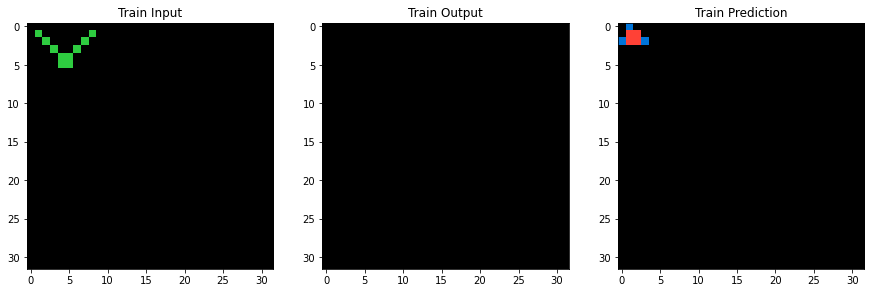

In [41]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(v[0], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y, cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(new_arr[0], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction');

In [48]:
x = X_train_big[125:126]
# print(x.shape)
# encoded_imgs = autoencoder.encoder(x.reshape((1,32,32) +(1,)))
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

pred_x = autoencoder.predict(x.reshape(1,32,32,1))
pred_x = pred_x.reshape(32,32)
pred_x = np.around(pred_x,1)*10

     

x = (x.reshape(32,32))*10

y = y_train_big[125]*10



test = X_test_big[40]*10

test = (test.reshape(32,32))#*10

encoded_imgs2 = autoencoder.encoder((X_test_big[125:126]).reshape(X_test_big[125:126].shape +(1,))).numpy()
decoded_imgs2 = autoencoder.decoder(encoded_imgs2).numpy()

pred_t = (decoded_imgs2.reshape(32,32))*100
pred_t = np.around(pred_t,1)*10

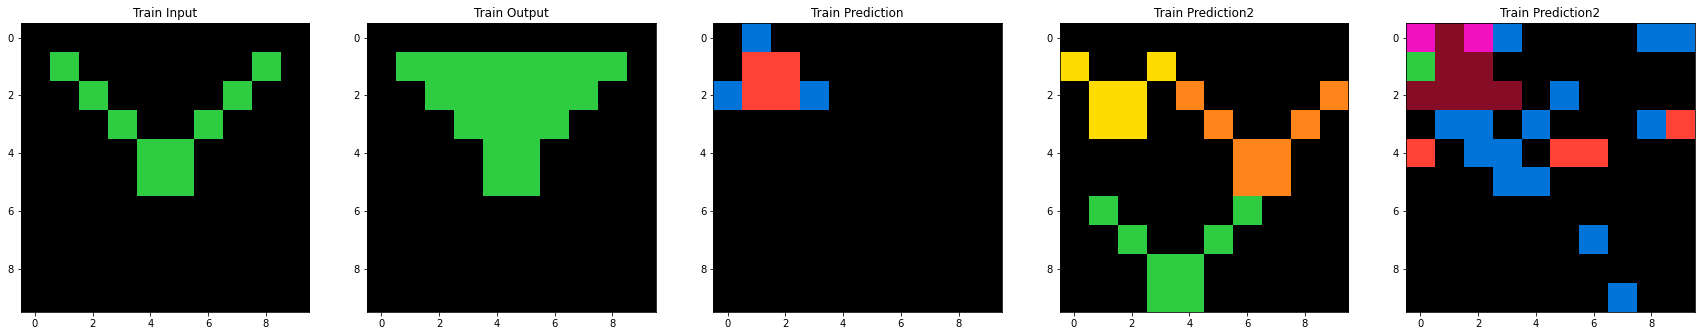

In [49]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 5, figsize=(30,30))
ax[0].imshow(x[:10,:10], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y[:10,:10], cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(pred_x[:10,:10], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(test[:10,:10], cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2')
ax[4].imshow(pred_t[:10,:10], cmap=cmap, norm=norm)
ax[4].set_title('Train Prediction2');

In [47]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                262208    
Total params: 262,368
Trainable params: 262,368
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              66560     
____________________________

In [42]:
pred = autoencoder2.predict(w).reshape(1,32,32)

In [43]:
pred.shape

(1, 32, 32)

In [44]:
new_arr = np.around(pred,1)*10

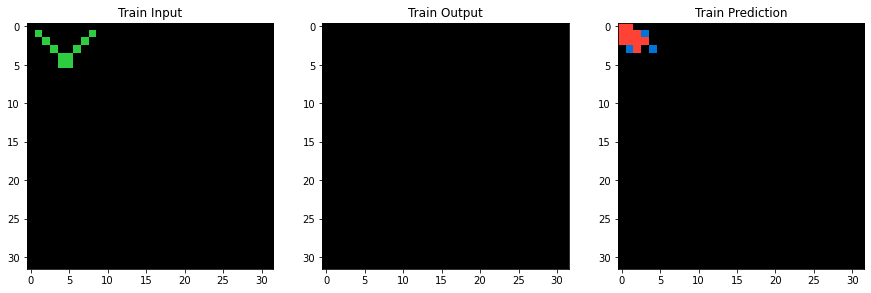

In [45]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(v[0], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y, cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(new_arr[0], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction');

In [50]:
x = X_train_big[125:126]
# print(x.shape)
# encoded_imgs = autoencoder.encoder(x.reshape((1,32,32) +(1,)))
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

pred_x = autoencoder2.predict(x.reshape(1,32,32,1))
pred_x = pred_x.reshape(32,32)
pred_x = np.around(pred_x,1)*10

     

x = (x.reshape(32,32))*10

y = y_train_big[125]*10



test = X_test_big[40]*10

test = (test.reshape(32,32))#*10

encoded_imgs2 = autoencoder2.encoder((X_test_big[125:126]).reshape(X_test_big[125:126].shape +(1,))).numpy()
decoded_imgs2 = autoencoder2.decoder(encoded_imgs2).numpy()

pred_t = (decoded_imgs2.reshape(32,32))*100
pred_t = np.around(pred_t,1)*10

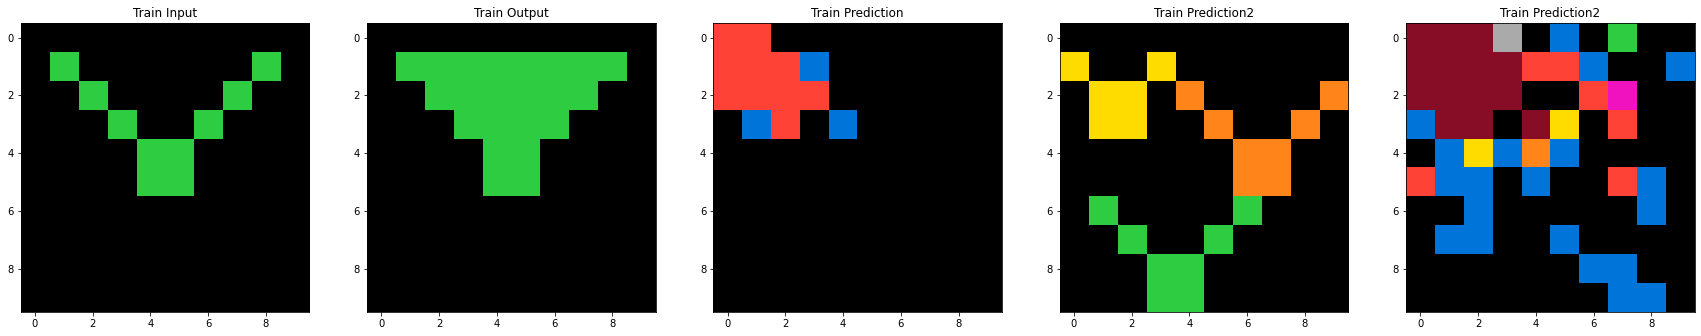

In [51]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 5, figsize=(30,30))
ax[0].imshow(x[:10,:10], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y[:10,:10], cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(pred_x[:10,:10], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(test[:10,:10], cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2')
ax[4].imshow(pred_t[:10,:10], cmap=cmap, norm=norm)
ax[4].set_title('Train Prediction2');